<a href="https://colab.research.google.com/github/tejaswiniat/338a308c0e76fcfa844dd52ed96f5bb4/blob/master/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


In [2]:
from google.colab import files
data_to_load = files.upload()

Saving Digit_data.xlsx to Digit_data.xlsx


In [4]:
data = pd.read_excel('Digit_data.xlsx')

In [5]:
# Basic Info
print("Basic Information:")
print(data.info())

# Checking for Missing Values
print("\nMissing Values:")
print(data.isnull().sum())

# Summary Statistics for Numerical Features
print("\nSummary Statistics:")
print(data.describe())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       2278 non-null   int64  
 1   City       2278 non-null   object 
 2   age_group  2278 non-null   object 
 3   RIDAGEYR   2278 non-null   int64  
 4   RIAGENDR   2278 non-null   int64  
 5   PAQ605     2278 non-null   int64  
 6   BMXBMI     2278 non-null   float64
 7   LBXGLU     2278 non-null   int64  
 8   DIQ010     2278 non-null   int64  
 9   LBXGLT     2278 non-null   int64  
 10  LBXIN      2278 non-null   float64
dtypes: float64(2), int64(7), object(2)
memory usage: 195.9+ KB
None

Missing Values:
SEQN         0
City         0
age_group    0
RIDAGEYR     0
RIAGENDR     0
PAQ605       0
BMXBMI       0
LBXGLU       0
DIQ010       0
LBXGLT       0
LBXIN        0
dtype: int64

Summary Statistics:
               SEQN     RIDAGEYR     RIAGENDR       PAQ605       BMXB

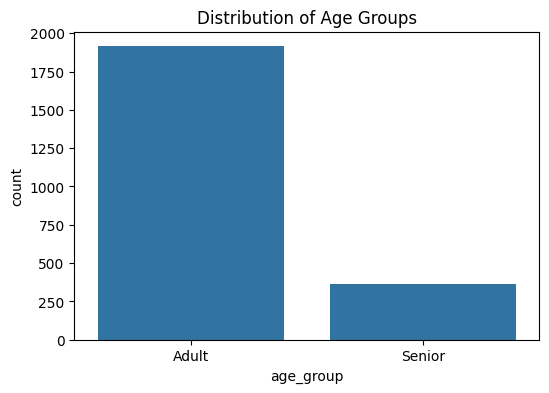

In [6]:
# Distribution of Target Variable (age_group)
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='age_group')
plt.title('Distribution of Age Groups')
plt.show()

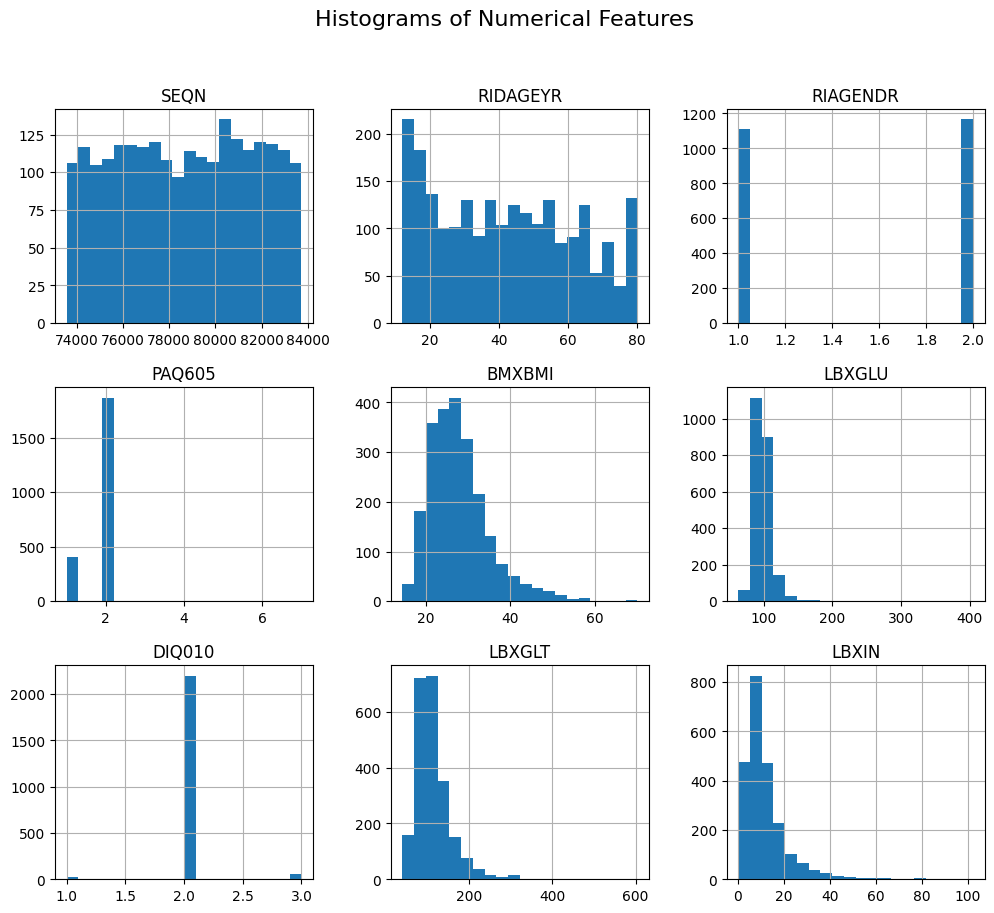

In [7]:
# Distribution of Numerical Features
numerical_columns = data.select_dtypes(include=[np.number]).columns
data[numerical_columns].hist(bins=20, figsize=(12, 10))
plt.suptitle('Histograms of Numerical Features', fontsize=16)
plt.show()

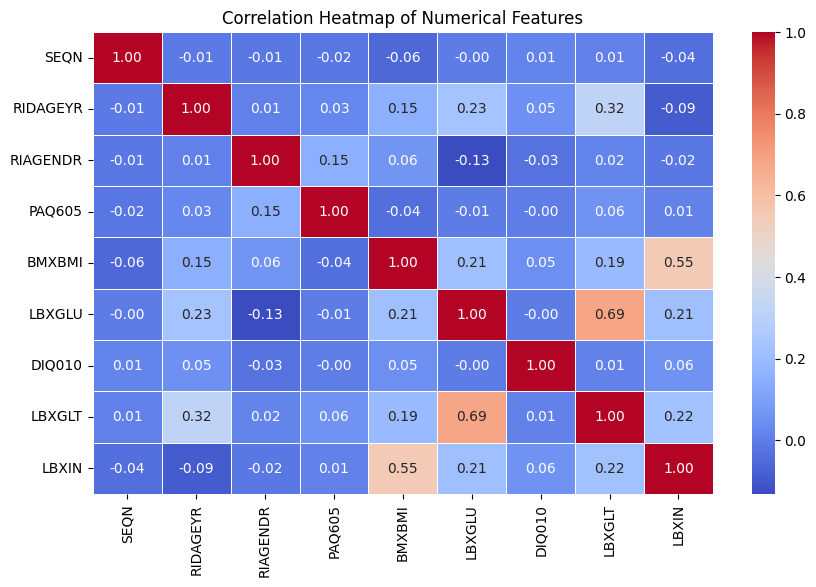

In [8]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
corr_matrix = data[numerical_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

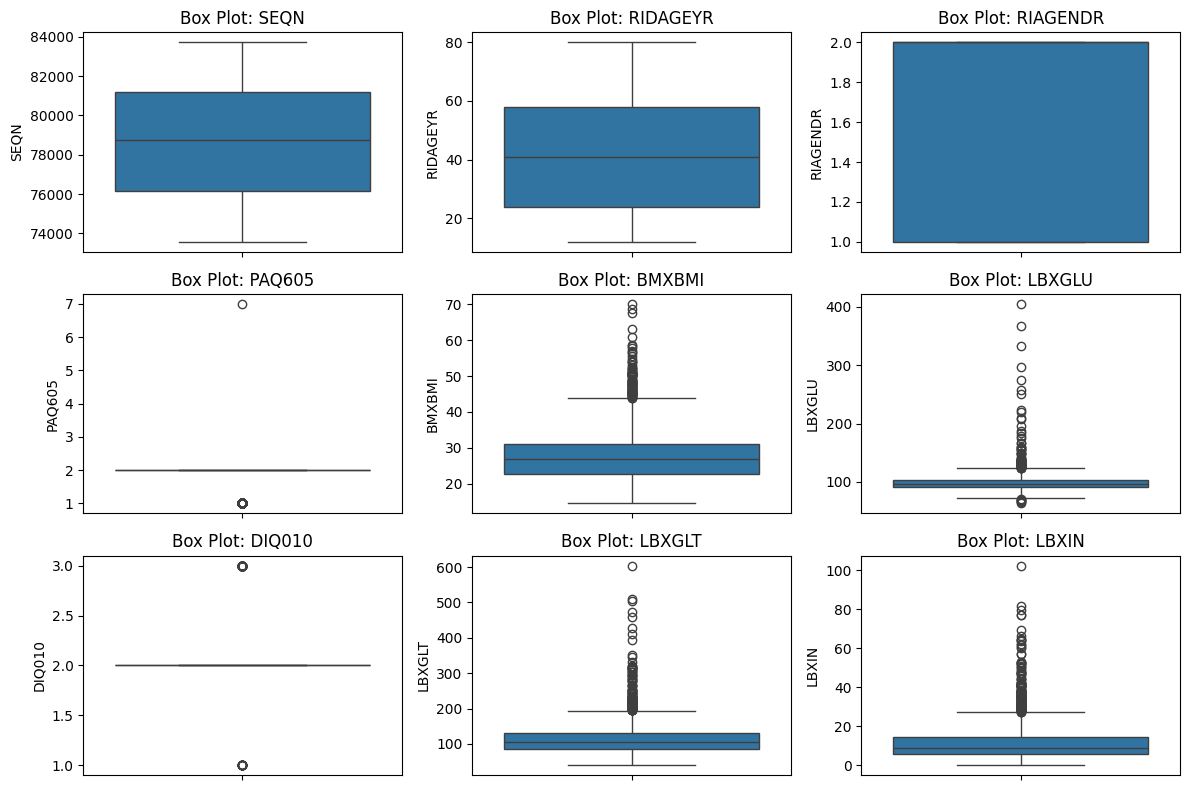

In [10]:
# Box Plots for Outlier Detection
plt.figure(figsize=(12, 8))

num_cols = len(numerical_columns)
num_rows = (num_cols + 2) // 3

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, 3, i)
    sns.boxplot(data[column])
    plt.title(f'Box Plot: {column}')
plt.tight_layout()
plt.show()

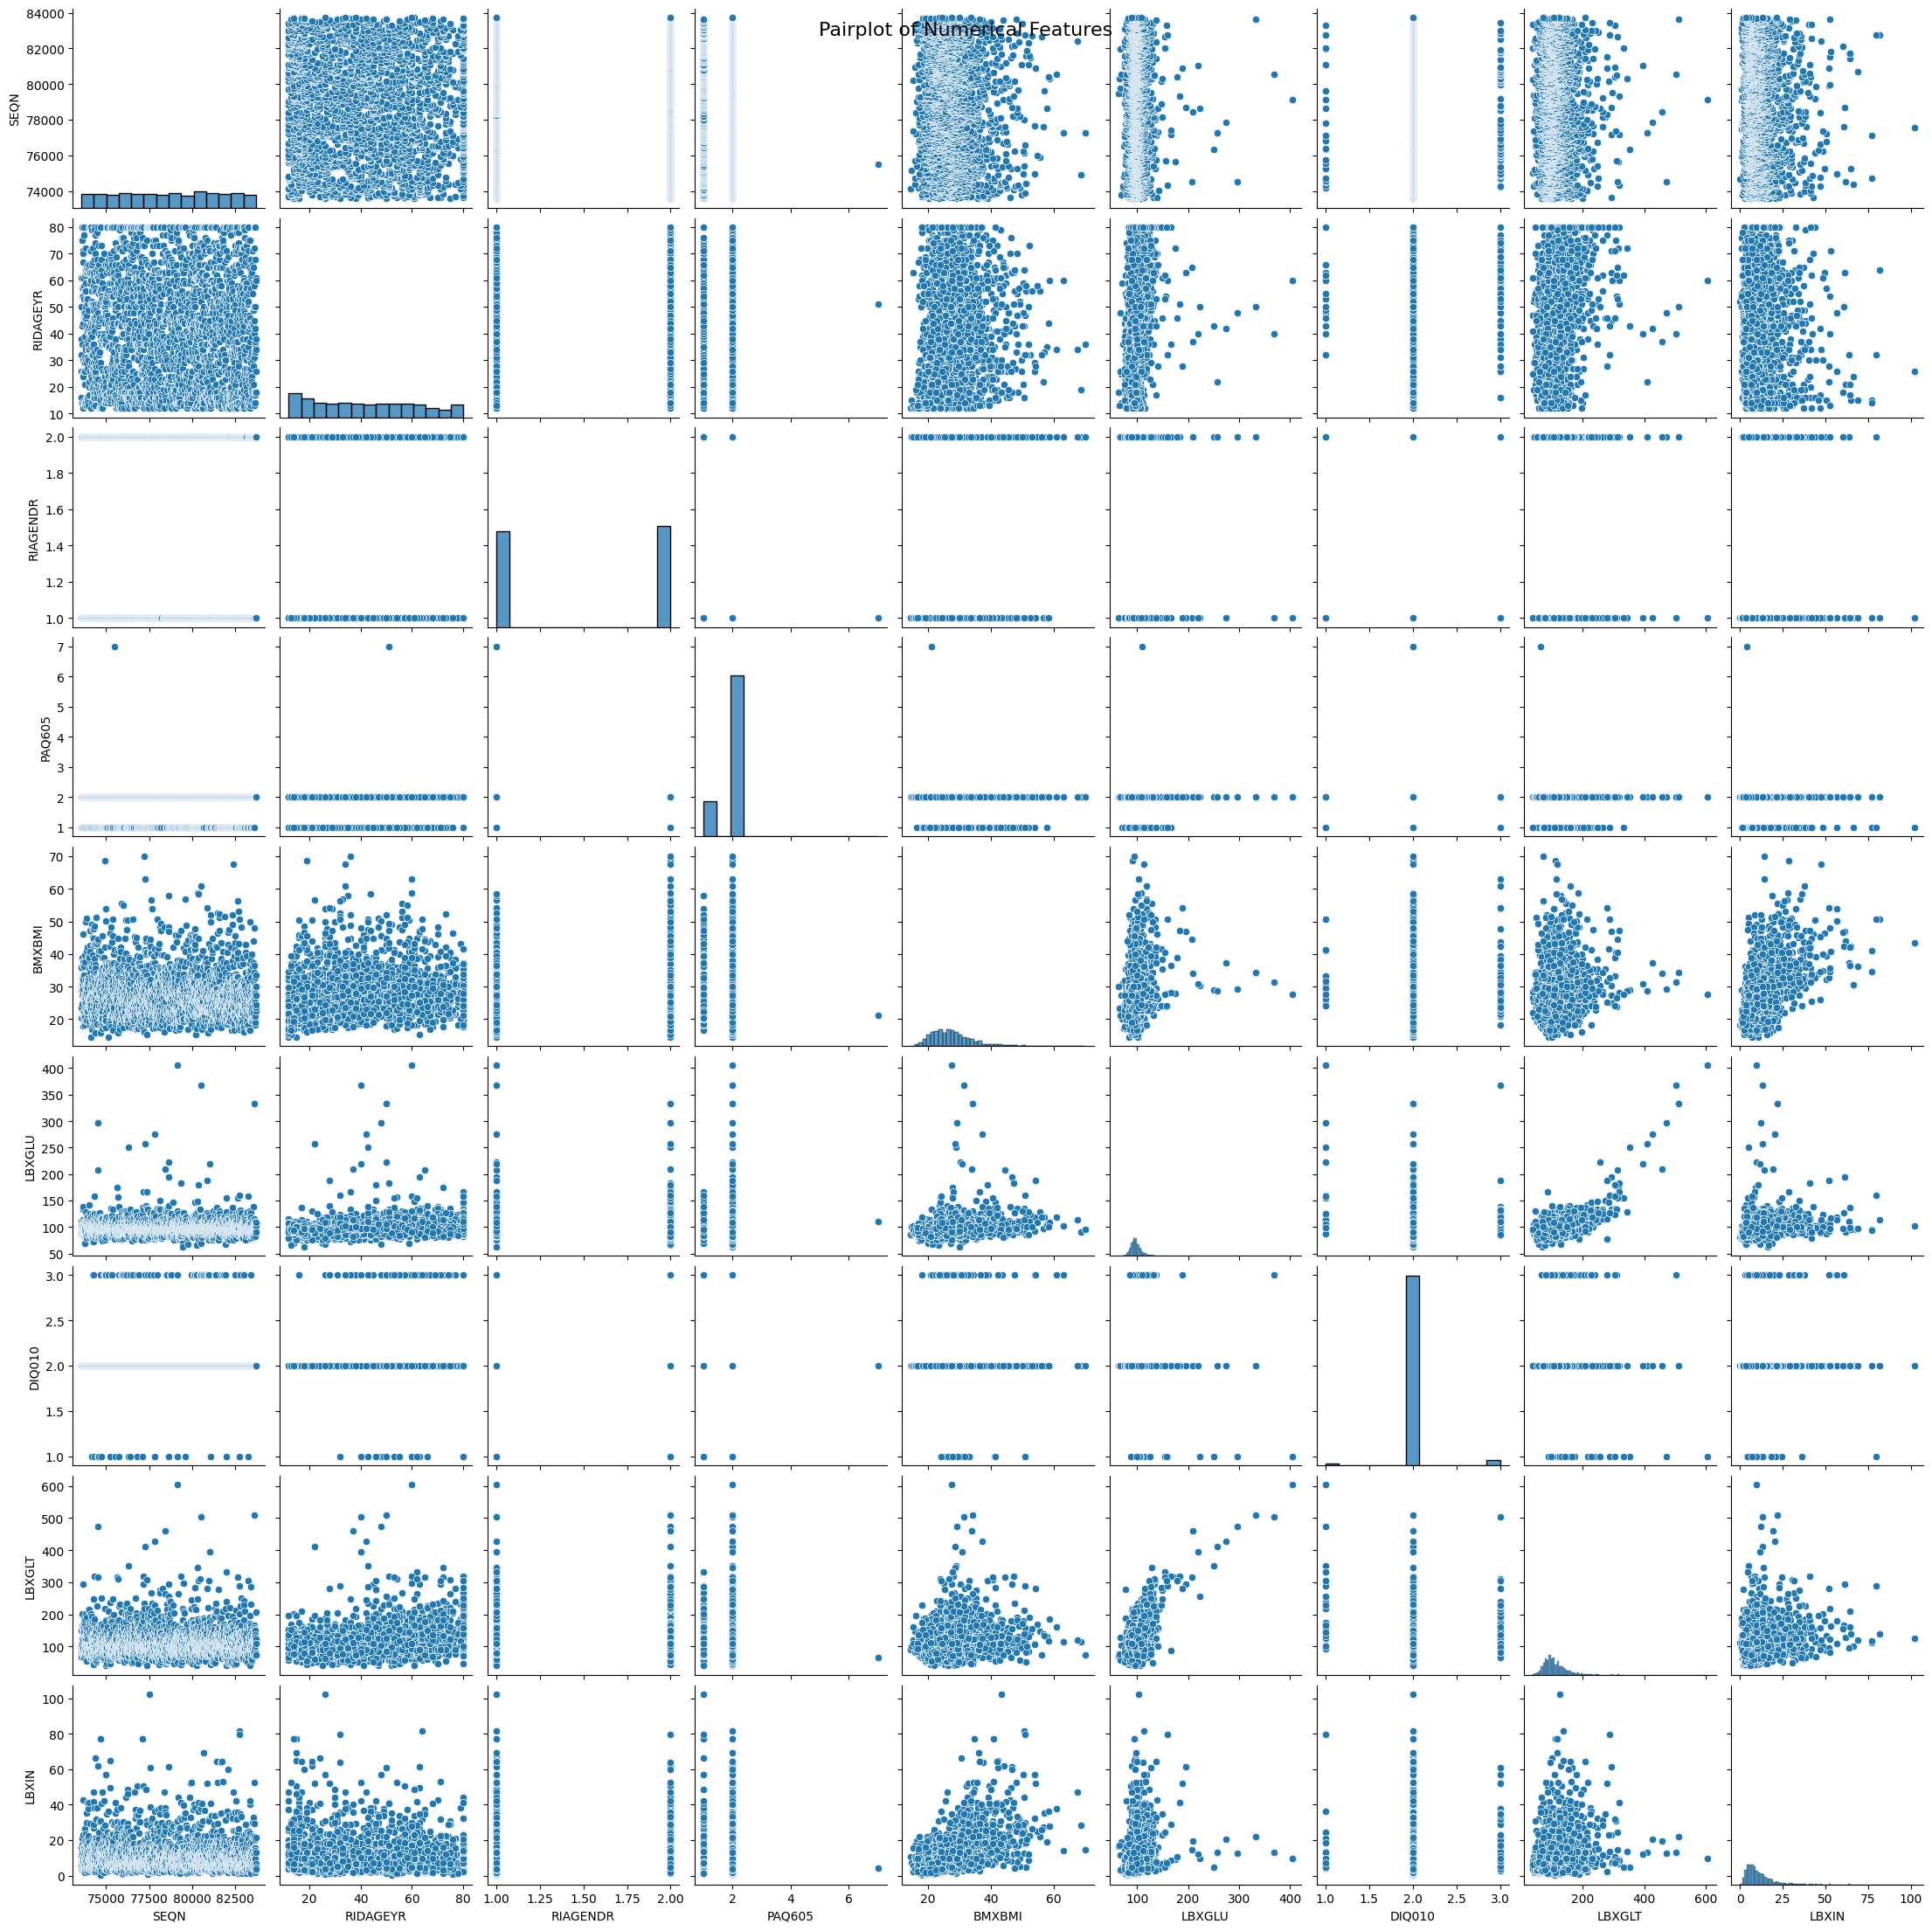

In [11]:
# Pairplot to Visualize Relationships Between Features
sns.pairplot(data[numerical_columns], height=2.5)
plt.suptitle('Pairplot of Numerical Features', fontsize=16)
plt.show()

<Figure size 1200x800 with 0 Axes>

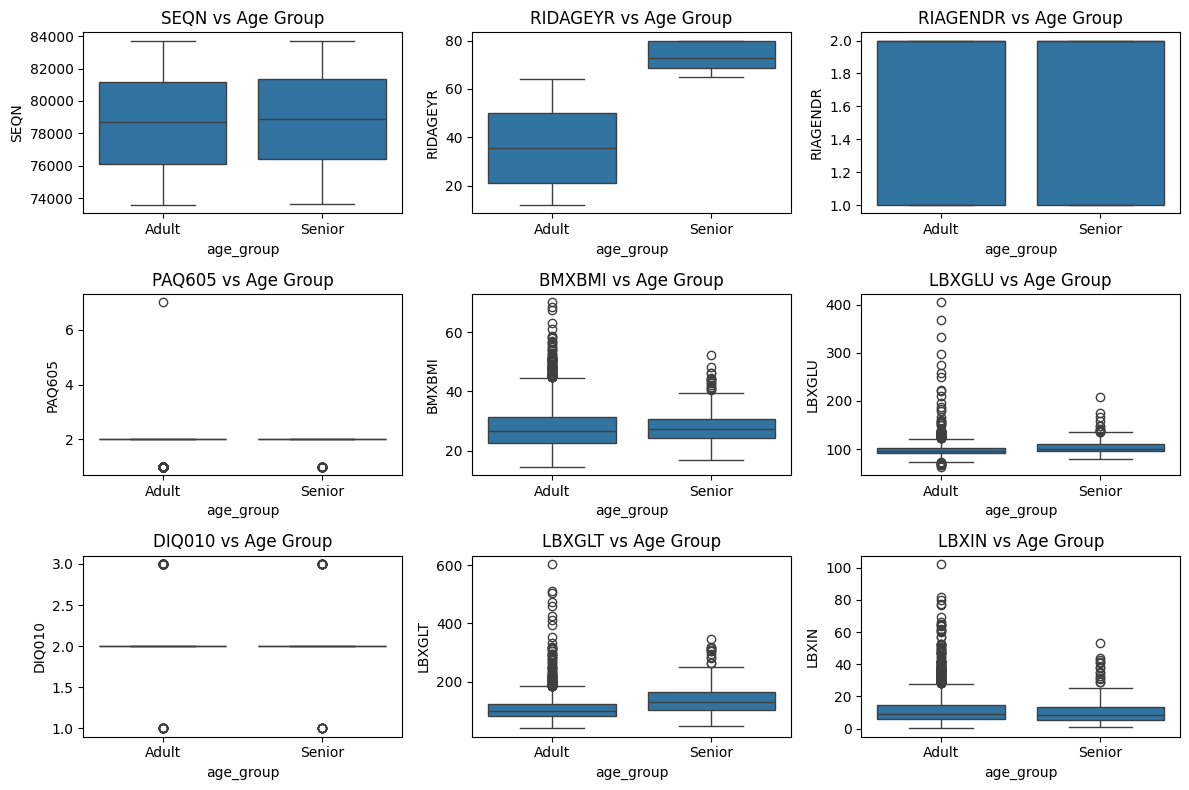

In [13]:
# Analyze Relationship between Numerical Features and Age Group
plt.figure(figsize=(12, 8))
num_cols = len(numerical_columns)
num_rows = (num_cols + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(12, 8))
axes = axes.flatten()
for i, column in enumerate(numerical_columns):
    sns.boxplot(x='age_group', y=column, data=data, ax=axes[i])
    axes[i].set_title(f'{column} vs Age Group')

# Hide any unused subplots
for i in range(len(numerical_columns), num_rows * 3):
    axes[i].set_visible(False)
plt.tight_layout()
plt.show()

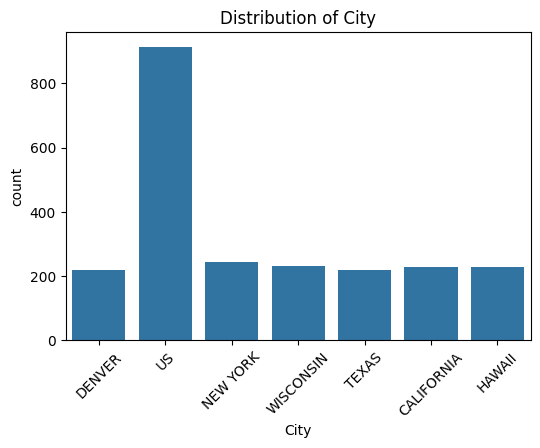

In [14]:
# Visualize Categorical Features (City, Age Group)
plt.figure(figsize=(6, 4))
sns.countplot(x='City', data=data)
plt.title('Distribution of City')
plt.xticks(rotation=45)
plt.show()

In [24]:
label_encoder = LabelEncoder()
data['age_group_encoded'] = label_encoder.fit_transform(data['age_group'])


In [28]:
X = data.drop(columns=['age_group', 'age_group_encoded', 'SEQN', 'City'])
y = data['age_group_encoded']


In [29]:
X = data[numerical_columns]
X.head()

,RIDAGEYR,BMXBMI,LBXGLU,LBXGLT,LBXIN
0,61,35.7,110,150,14.91
1,26,20.3,89,80,3.85
2,16,23.2,89,68,6.14
3,32,28.9,104,84,16.15
4,38,35.9,103,81,10.92


In [25]:
# Check for Multicollinearity (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add constant to X for VIF calculation
X = data[numerical_columns]
X = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factor (VIF):")
print(vif_data)


Variance Inflation Factor (VIF):
    Feature        VIF
0     const  46.697450
1  RIDAGEYR   1.207050
2    BMXBMI   1.533152
3    LBXGLU   1.911705
4    LBXGLT   2.031247
5     LBXIN   1.579923


Most features have low VIFs (close to 1), meaning there’s no significant multicollinearity among the predictors.
The const term's high VIF is typical and does not need further investigation.
There doesn't seem to be an immediate concern with multicollinearity in this dataset based on the VIF values.

In [20]:
# Using Z-score to identify outliers (Threshold > 3 standard deviations)
from scipy.stats import zscore

# Calculate Z-scores
z_scores = np.abs(zscore(data[numerical_columns]))

# Identify outliers
outliers = (z_scores > 3).all(axis=1)  # Outliers are rows where all features have Z-score > 3
print(f"\nNumber of outliers detected: {np.sum(outliers)}")

# Remove outliers
data_no_outliers = data[~outliers]
print(f"Data after removing outliers: {data_no_outliers.shape}")


Number of outliers detected: 0
Data after removing outliers: (2278, 11)


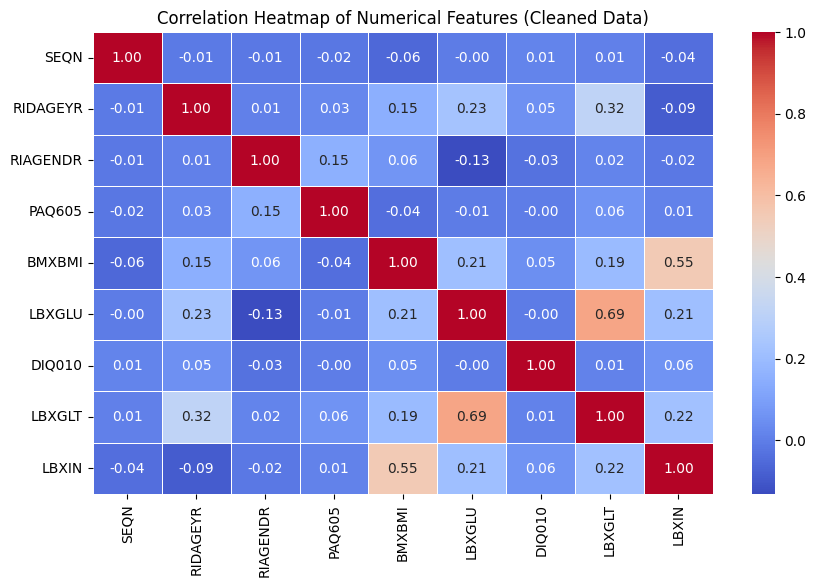

In [19]:
# Recompute correlation heatmap
numerical_columns_clean = data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 6))
corr_matrix_clean = data[numerical_columns_clean].corr()
sns.heatmap(corr_matrix_clean, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features (Cleaned Data)')
plt.show()

In [21]:
from scipy.stats import chi2_contingency

# Create a contingency table of 'City' and 'age_group'
contingency_table = pd.crosstab(data['City'], data['age_group'])

# Perform the Chi-Square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_val}")

Chi-Square Statistic: 5.675000591799982
P-Value: 0.46056277848145


Since the p-value is 0.4606, which is greater than 0.05, we fail to reject the null hypothesis. This indicates that there is no significant association between the age_group and City at the 5% significance level.

In [22]:
from scipy import stats

# List of numerical columns to test
numerical_columns = ['RIDAGEYR', 'BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']

# Group the data by 'City' and perform ANOVA for each numerical feature
anova_results = {}
for column in numerical_columns:
    city_groups = [data[data['City'] == city][column].dropna() for city in data['City'].unique()]
    f_stat, p_value = stats.f_oneway(*city_groups)
    anova_results[column] = {'F-Statistic': f_stat, 'P-Value': p_value}

# Display the results
anova_results_df = pd.DataFrame(anova_results).T
print(anova_results_df)

          F-Statistic   P-Value
RIDAGEYR     1.203308  0.301444
BMXBMI       0.741957  0.615844
LBXGLU       0.746133  0.612499
LBXGLT       1.457426  0.189012
LBXIN        1.108961  0.354442


None of the features show a statistically significant difference between the city categories based on the ANOVA results (all p-values > 0.05). Therefore, these features do not appear to influence the age_group variable significantly.



In [30]:
X = data.drop(columns=['age_group', 'age_group_encoded', 'SEQN', 'City'])
y = data['age_group_encoded']

In [31]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [32]:
# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [34]:
# Feature importance analysis
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
# Display feature importances
print("Feature Importances:")
print(feature_importances)

Feature Importances:
    Feature  Importance
0  RIDAGEYR    0.871114
6    LBXGLT    0.047379
4    LBXGLU    0.024256
7     LBXIN    0.023864
3    BMXBMI    0.023728
2    PAQ605    0.004516
5    DIQ010    0.002854
1  RIAGENDR    0.002289


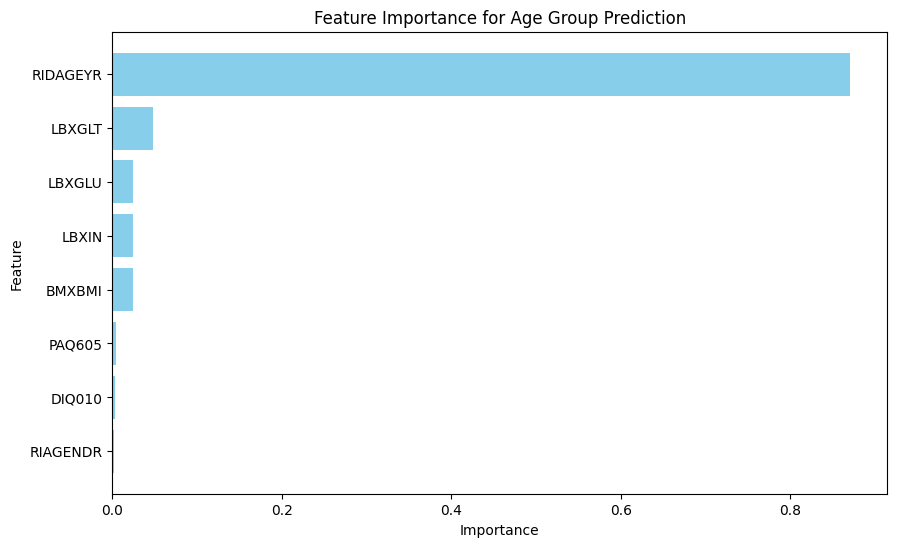

In [35]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Age Group Prediction')
plt.gca().invert_yaxis()
plt.show()

 The model relies heavily on age (RIDAGEYR) to differentiate between age groups or classes.
Features like LBXGLT and LBXGLU contribute to a lesser extent, but the model’s focus is primarily on age.
Less Important Features: Physical activity, diabetes status, and gender are of minimal importance in this context.

In [36]:
X_revised=data[['RIDAGEYR', 'BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']]
y_revised=data['age_group_encoded']
# Train-test split
X_revised_train, X_revised_test, y_revised_train, y_revised_test = train_test_split(X_revised, y_revised, test_size=0.3, random_state=42, stratify=y)

In [38]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

#Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_revised_train, y_revised_train)

# Train a Random Forest Classifier on resampled data
rf_model_smote = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model_smote.fit(X_resampled, y_resampled)

# Evaluate model performance after SMOTE
y_pred_smote = rf_model_smote.predict(X_revised_test)
print("Classification Report (After SMOTE):")
print(classification_report(y_revised_test, y_pred_smote, target_names=label_encoder.classes_))

# 2. Apply class weights to the Random Forest model
rf_model_weighted = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf_model_weighted.fit(X_revised_train, y_revised_train)

# Evaluate model performance after applying class weights
y_pred_weighted = rf_model_weighted.predict(X_revised_test)
print("\nClassification Report (After Class Weights):")
print(classification_report(y_test, y_pred_weighted, target_names=label_encoder.classes_))

Classification Report (After SMOTE):
              precision    recall  f1-score   support

       Adult       1.00      1.00      1.00       575
      Senior       1.00      1.00      1.00       109

    accuracy                           1.00       684
   macro avg       1.00      1.00      1.00       684
weighted avg       1.00      1.00      1.00       684


Classification Report (After Class Weights):
              precision    recall  f1-score   support

       Adult       1.00      1.00      1.00       575
      Senior       1.00      1.00      1.00       109

    accuracy                           1.00       684
   macro avg       1.00      1.00      1.00       684
weighted avg       1.00      1.00      1.00       684



In [39]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model_smote, X_resampled, y_resampled, cv=5, scoring='accuracy')

# Display results
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

Cross-Validation Accuracy Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0
Standard Deviation of CV Accuracy: 0.0


## XGBOOST

In [40]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
model = xgb.XGBClassifier(
    objective='binary:logistic',  # For binary classification (Adult vs Senior)
    eval_metric='logloss',  # Log loss for binary classification
    learning_rate=0.1,  # Learning rate
    n_estimators=100,  # Number of boosting rounds
    max_depth=5,  # Maximum depth of trees
    subsample=0.8,  # Subsample ratio
    colsample_bytree=0.8  # Column sample ratio
)

# Fit the model
model.fit(X_revised_train, y_revised_train)

# 5. Make predictions
y_pred = model.predict(X_revised_test)

# 6. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Classification report (Precision, Recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 7. Feature importances
print("\nFeature Importances:")
feature_importances = model.feature_importances_
for feature, importance in zip(X.columns, feature_importances):
    print(f'{feature}: {importance:.4f}')



Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       575
           1       1.00      1.00      1.00       109

    accuracy                           1.00       684
   macro avg       1.00      1.00      1.00       684
weighted avg       1.00      1.00      1.00       684


Feature Importances:
RIDAGEYR: 0.8834
RIAGENDR: 0.0232
PAQ605: 0.0191
BMXBMI: 0.0523
LBXGLU: 0.0221


In [41]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# Print cross-validation results
print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Mean cross-validation accuracy: {np.mean(cv_scores):.4f}')

Cross-validation accuracy scores: [1. 1. 1. 1. 1.]
Mean cross-validation accuracy: 1.0000
